# Dependencies

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load
import time
from scipy.interpolate import PchipInterpolator
import scipy
from collections import defaultdict

from tqdm import tqdm

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

from itertools import chain

import os

# Data

In [2]:
# Specify the directory path
dir_path = "../files/data/TWIN/CS/CLEANED"

# Get all .csv files
csv_files = [f for f in os.listdir(dir_path) if f.endswith(".csv")]

In [3]:
df = pd.read_csv("../files/data/TWIN/CS/CLEANED/{}".format(csv_files[0]), index_col=False)
df = df[(df['a1/t'] > 0.5) | (df['a2/t'] > 0.5)]

for csv_file in tqdm(csv_files[1:]):
    df_ = pd.read_csv("../files/data/TWIN/CS/CLEANED/{}".format(csv_file), index_col=False)
    df_ = df_[(df_['a1/t'] > 0.5) | (df_['a2/t'] > 0.5)]
    df = pd.concat([df, df_], axis=0, ignore_index=True)

df

100%|██████████| 113/113 [01:58<00:00,  1.05s/it]


,c_index,W/R,a1/c1,a1/t,a2/c2,a2/t,r/t,b/t,phi_1,phi_2,K1-T,K2-T,K1-B,K2-B,K1-P,K2-P
0,10001.0,9.0,0.1,0.10,0.1,0.60,1.5,0.5,0.057913,0.057913,1.001637,2.461541,0.909263,2.013318,0.194829,0.257456
1,10001.0,9.0,0.1,0.10,0.1,0.60,1.5,0.5,0.069369,0.069369,1.019129,2.501316,0.924451,2.038030,0.198420,0.261537
2,10001.0,9.0,0.1,0.10,0.1,0.60,1.5,0.5,0.080826,0.080826,1.040924,2.550117,0.942919,2.068661,0.202709,0.266588
3,10001.0,9.0,0.1,0.10,0.1,0.60,1.5,0.5,0.092282,0.092282,1.064842,2.605406,0.963652,2.103567,0.207470,0.272278
4,10001.0,9.0,0.1,0.10,0.1,0.60,1.5,0.5,0.103739,0.103739,1.090858,2.664042,0.985919,2.141019,0.212626,0.278370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29501307,40000.0,40.0,10.0,0.95,10.0,0.95,1.0,0.5,0.574895,0.574895,5.050058,5.050058,-0.023568,-0.023558,1.244561,1.244561
29501308,40000.0,40.0,10.0,0.95,10.0,0.95,1.0,0.5,0.579214,0.579214,5.006533,5.006533,-0.040026,-0.040017,1.233883,1.233883
29501309,40000.0,40.0,10.0,0.95,10.0,0.95,1.0,0.5,0.583533,0.583533,4.957468,4.958069,-0.056097,-0.056092,1.221216,1.221216
29501310,40000.0,40.0,10.0,0.95,10.0,0.95,1.0,0.5,0.587853,0.587853,4.902685,4.902655,-0.071757,-0.071747,1.207423,1.207423


In [4]:
# Get unique combinations of the first four columns
CC_combinations = df.iloc[:, 1:8].drop_duplicates().to_numpy()

print(len(CC_combinations))

230479


In [5]:
print("Different W/r values: ", np.unique(CC_combinations[:,0], axis=0))
print("Different a1/c1 values: ", np.unique(CC_combinations[:,1], axis=0))
print("Different a1/t values: ", np.unique(CC_combinations[:,2], axis=0))
print("Different a2/c2 values: ", np.unique(CC_combinations[:,3], axis=0))
print("Different a2/t values: ", np.unique(CC_combinations[:,4], axis=0))
print("Different r/t values: ", np.unique(CC_combinations[:,5], axis=0))
print("Different b/t values: ", np.unique(CC_combinations[:,6], axis=0))

Different W/r values:  [  2.4   2.6   2.8   3.2   3.6   4.    4.6   5.2   5.8   6.4   7.    8.
   9.   10.   12.   16.   20.   30.   40.  100. ]
Different a1/c1 values:  [ 0.1     0.125   0.1667  0.2     0.25    0.333   0.5     0.667   0.75
  0.8     0.9     1.      1.1111  1.25    1.333   1.5     2.      3.
  6.     10.    ]
Different a1/t values:  [0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  0.95]
Different a2/c2 values:  [ 0.1     0.125   0.1667  0.2     0.25    0.333   0.5     0.667   0.75
  0.8     0.9     1.      1.1111  1.25    1.333   1.5     2.      3.
  6.     10.    ]
Different a2/t values:  [0.6  0.7  0.8  0.9  0.95]
Different r/t values:  [0.5 1.  1.5 2.  3.  5. ]
Different b/t values:  [0.5]


In [6]:
df.to_csv("../files/data/FINAL_CSV/TWIN_CORNER_CRACK_CS2_CS_THICKNESS.csv", index=False)

# Data Viz

In [4]:
df = pd.read_csv("../files/data/FINAL_CSV/TWIN/TWIN_CORNER_CRACK_CS2_THROUGH_THICKNESS.csv")
df

,c_index,W/R,a1/c1,a1/t,a2/c2,a2/t,r/t,b/t,phi_1,phi_2,K1-T,K2-T,K1-B,K2-B,K1-P,K2-P
0,10001.0,9.0,0.1,0.10,0.1,0.60,1.5,0.5,0.057913,0.057913,1.001637,2.461541,0.909263,2.013318,0.194829,0.257456
1,10001.0,9.0,0.1,0.10,0.1,0.60,1.5,0.5,0.069369,0.069369,1.019129,2.501316,0.924451,2.038030,0.198420,0.261537
2,10001.0,9.0,0.1,0.10,0.1,0.60,1.5,0.5,0.080826,0.080826,1.040924,2.550117,0.942919,2.068661,0.202709,0.266588
3,10001.0,9.0,0.1,0.10,0.1,0.60,1.5,0.5,0.092282,0.092282,1.064842,2.605406,0.963652,2.103567,0.207470,0.272278
4,10001.0,9.0,0.1,0.10,0.1,0.60,1.5,0.5,0.103739,0.103739,1.090858,2.664042,0.985919,2.141019,0.212626,0.278370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29501307,40000.0,40.0,10.0,0.95,10.0,0.95,1.0,0.5,0.574895,0.574895,5.050058,5.050058,-0.023568,-0.023558,1.244561,1.244561
29501308,40000.0,40.0,10.0,0.95,10.0,0.95,1.0,0.5,0.579214,0.579214,5.006533,5.006533,-0.040026,-0.040017,1.233883,1.233883
29501309,40000.0,40.0,10.0,0.95,10.0,0.95,1.0,0.5,0.583533,0.583533,4.957468,4.958069,-0.056097,-0.056092,1.221216,1.221216
29501310,40000.0,40.0,10.0,0.95,10.0,0.95,1.0,0.5,0.587853,0.587853,4.902685,4.902655,-0.071757,-0.071747,1.207423,1.207423


In [5]:
crack_idx = df['c_index'].unique()

crack_idx_train, crack_idx_test = train_test_split(crack_idx, test_size=0.25, random_state=10)

# Create a boolean mask for rows where the value in '"c_index"' is in list1
train_list_mask = df["c_index"].isin(crack_idx_train)

# Create a boolean mask for rows where the value in '"c_index"' is in list2
test_list_mask = df["c_index"].isin(crack_idx_test)

# Use the masks to create the two new DataFrames
df_train = df[train_list_mask].copy() # Using .copy() to avoid SettingWithCopyWarning
df_test = df[test_list_mask].copy() # Using .copy() to avoid SettingWithCopyWarning


assert (np.sort(crack_idx_train) == np.sort(df_train['c_index'].unique())).all()
assert (np.sort(crack_idx_test) == np.sort(df_test['c_index'].unique())).all()

print(len(crack_idx_train))
print(len(crack_idx_test))

2040
680


In [6]:
# Save the cleaned and processed DataFrame to a new CSV file
df_train.to_csv("../files/data/FINAL_CSV/TWIN/TRAIN/TWIN_CORNER_CRACK_CS2_THROUGH_THICKNESS_TRAIN.csv", index=False)
df_test.to_csv("../files/data/FINAL_CSV/TWIN/TEST/TWIN_CORNER_CRACK_CS2_THROUGH_THICKNESS_TEST.csv", index=False)

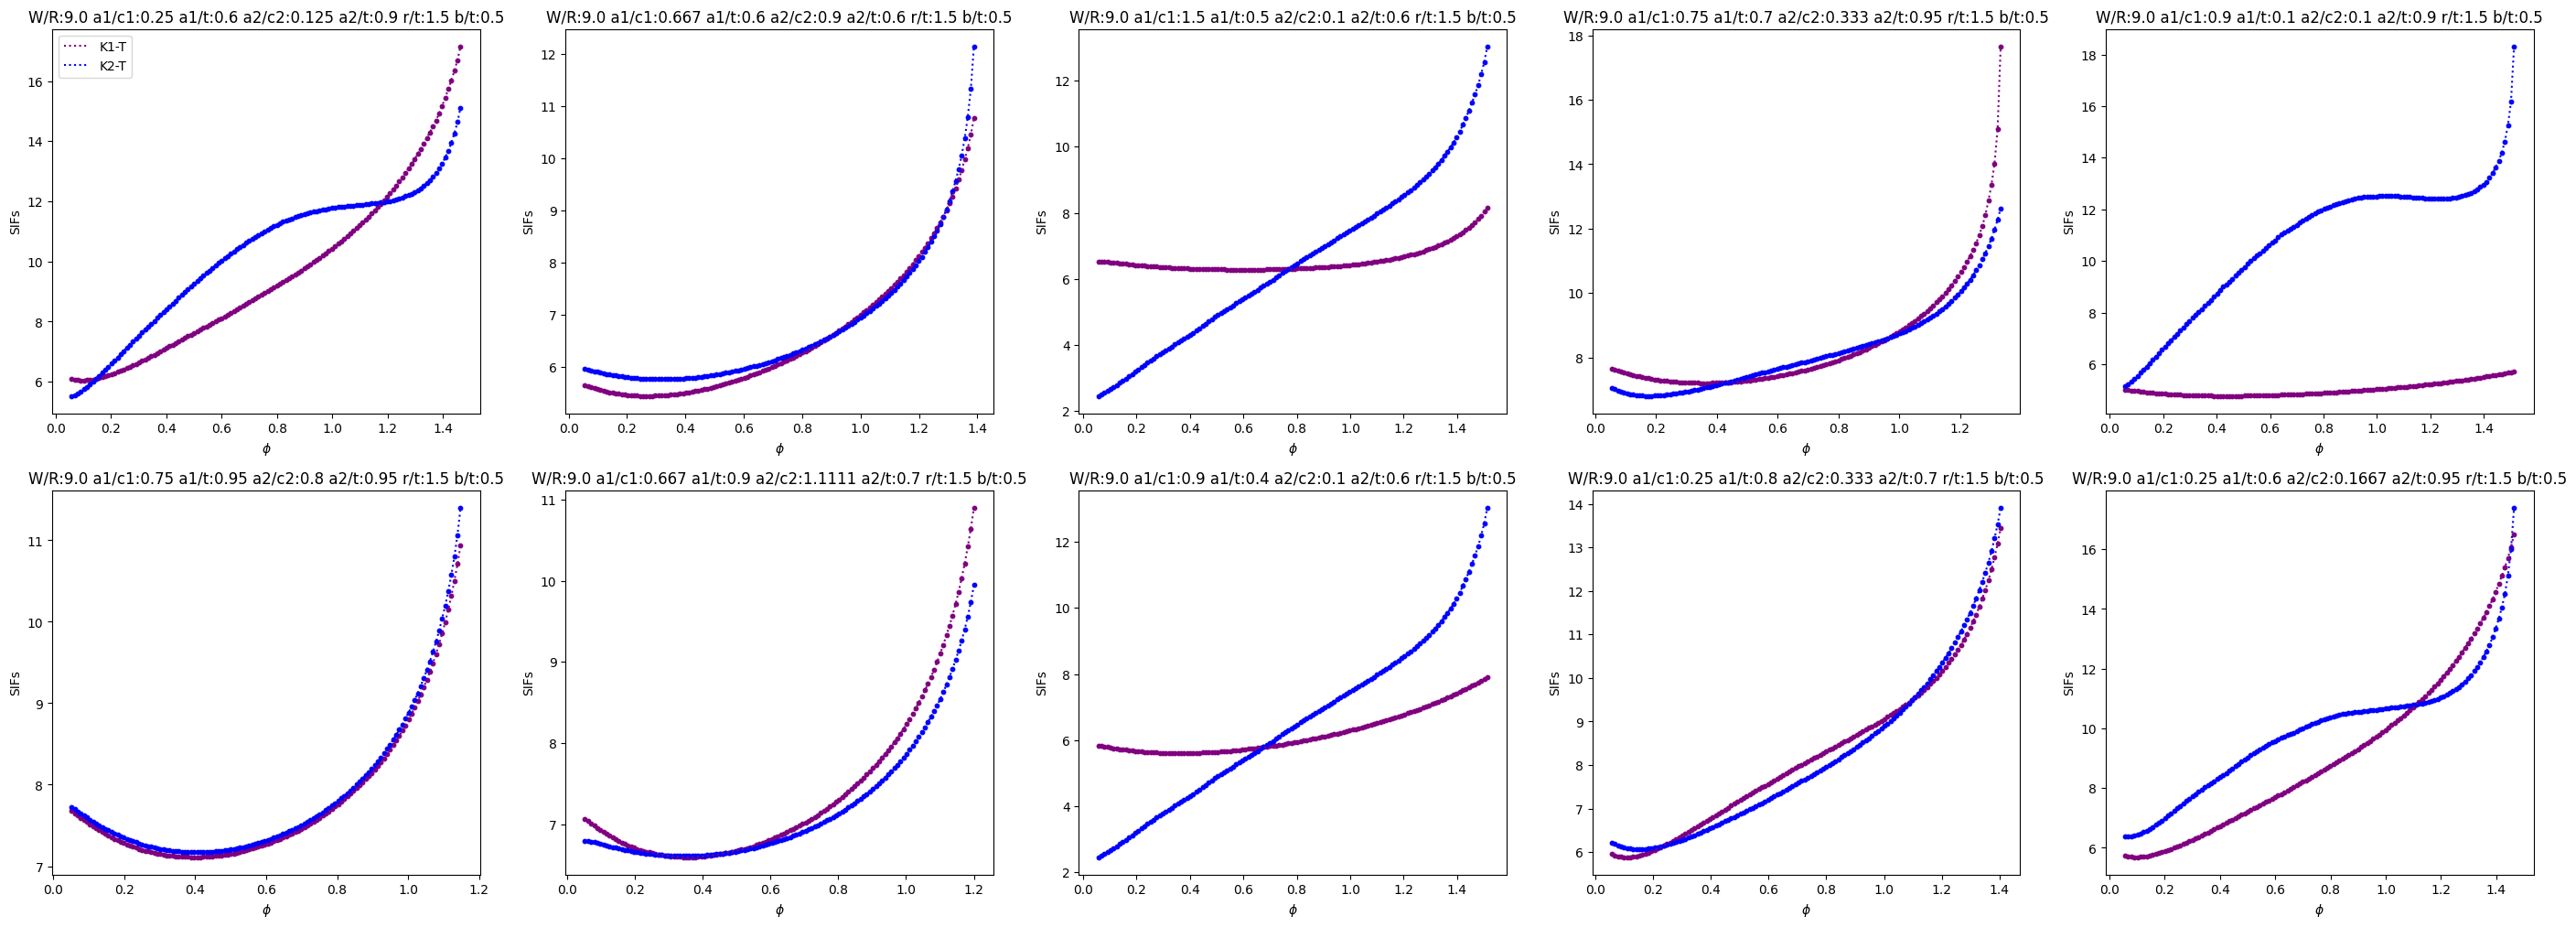

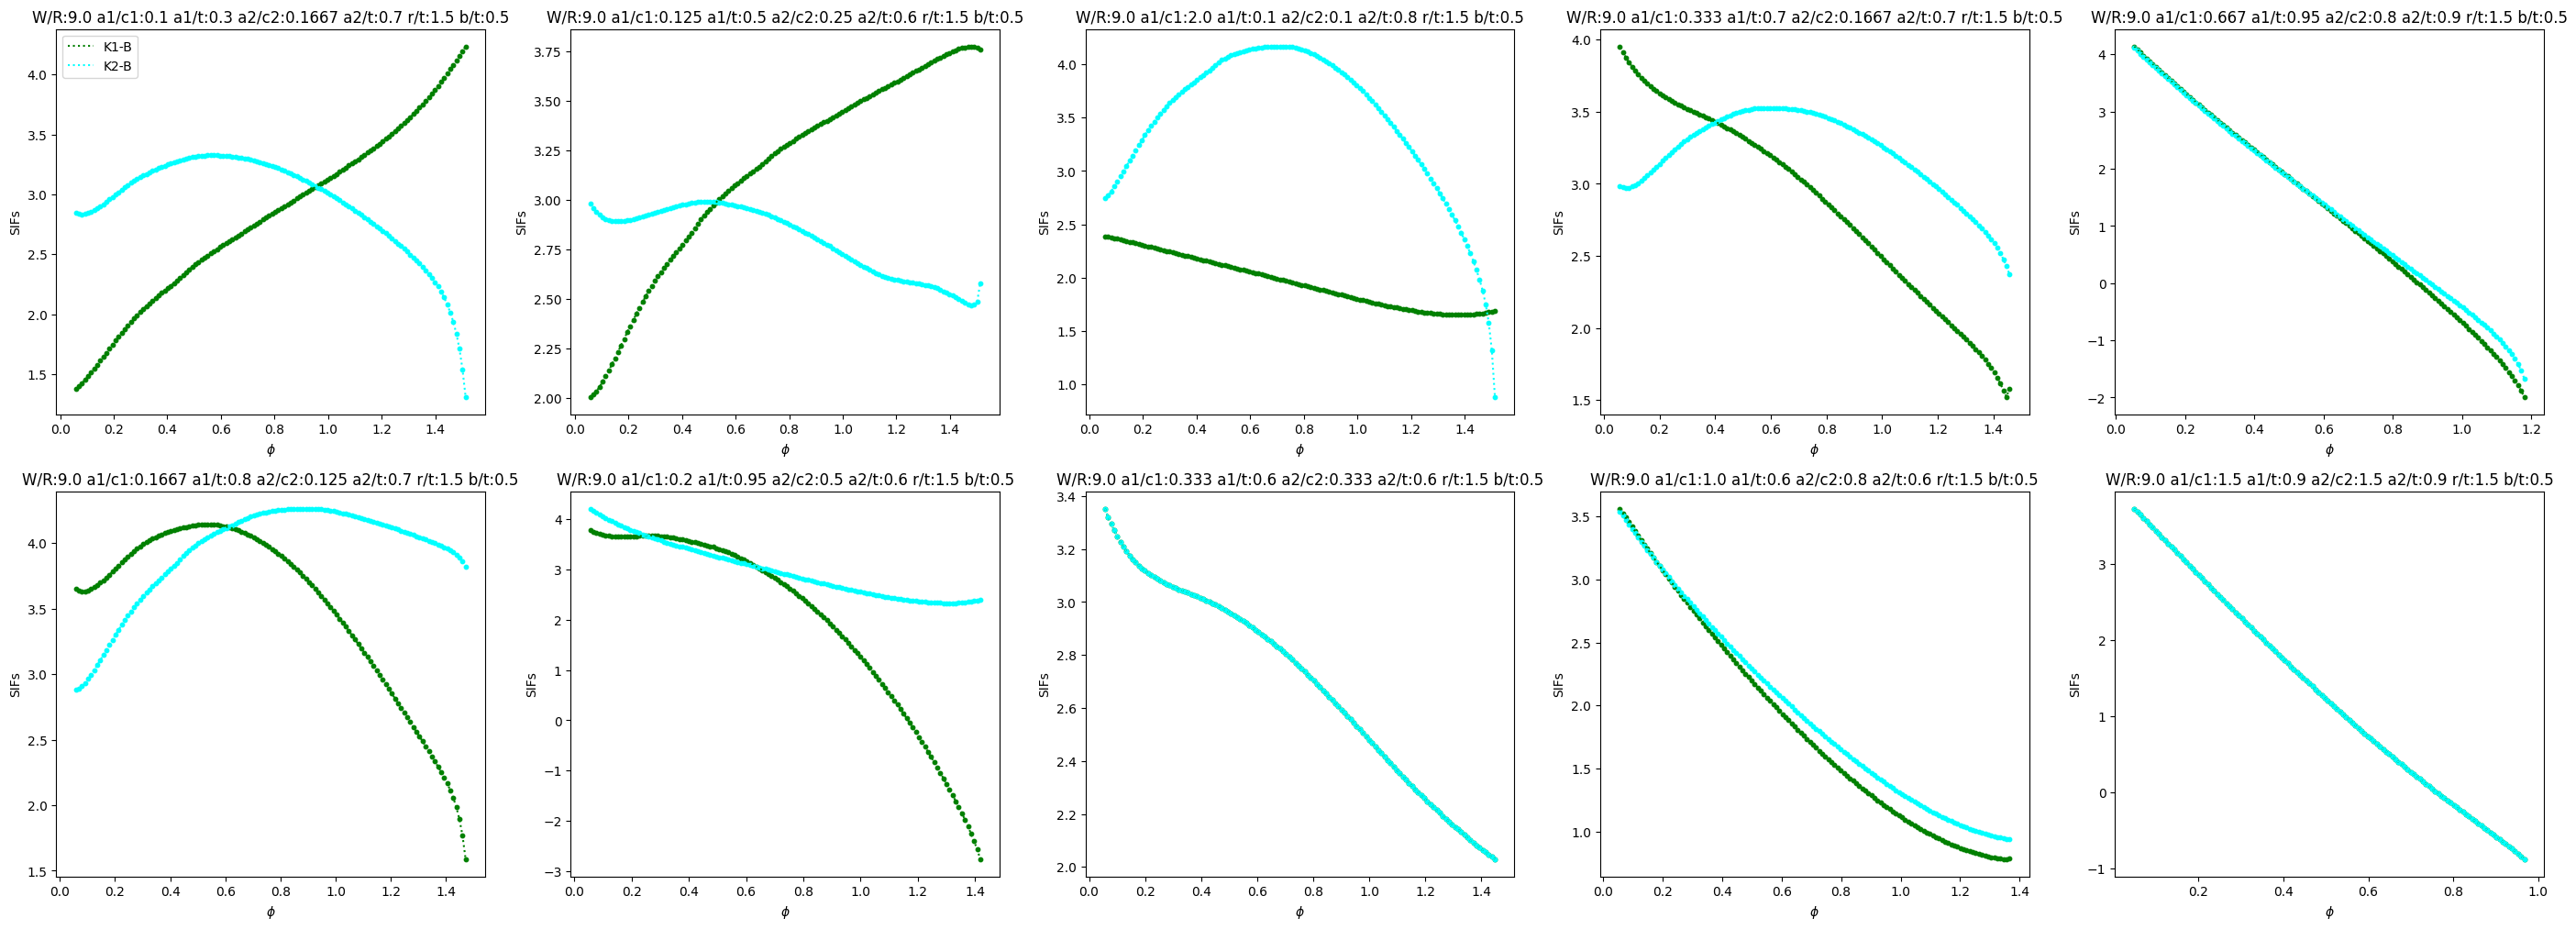

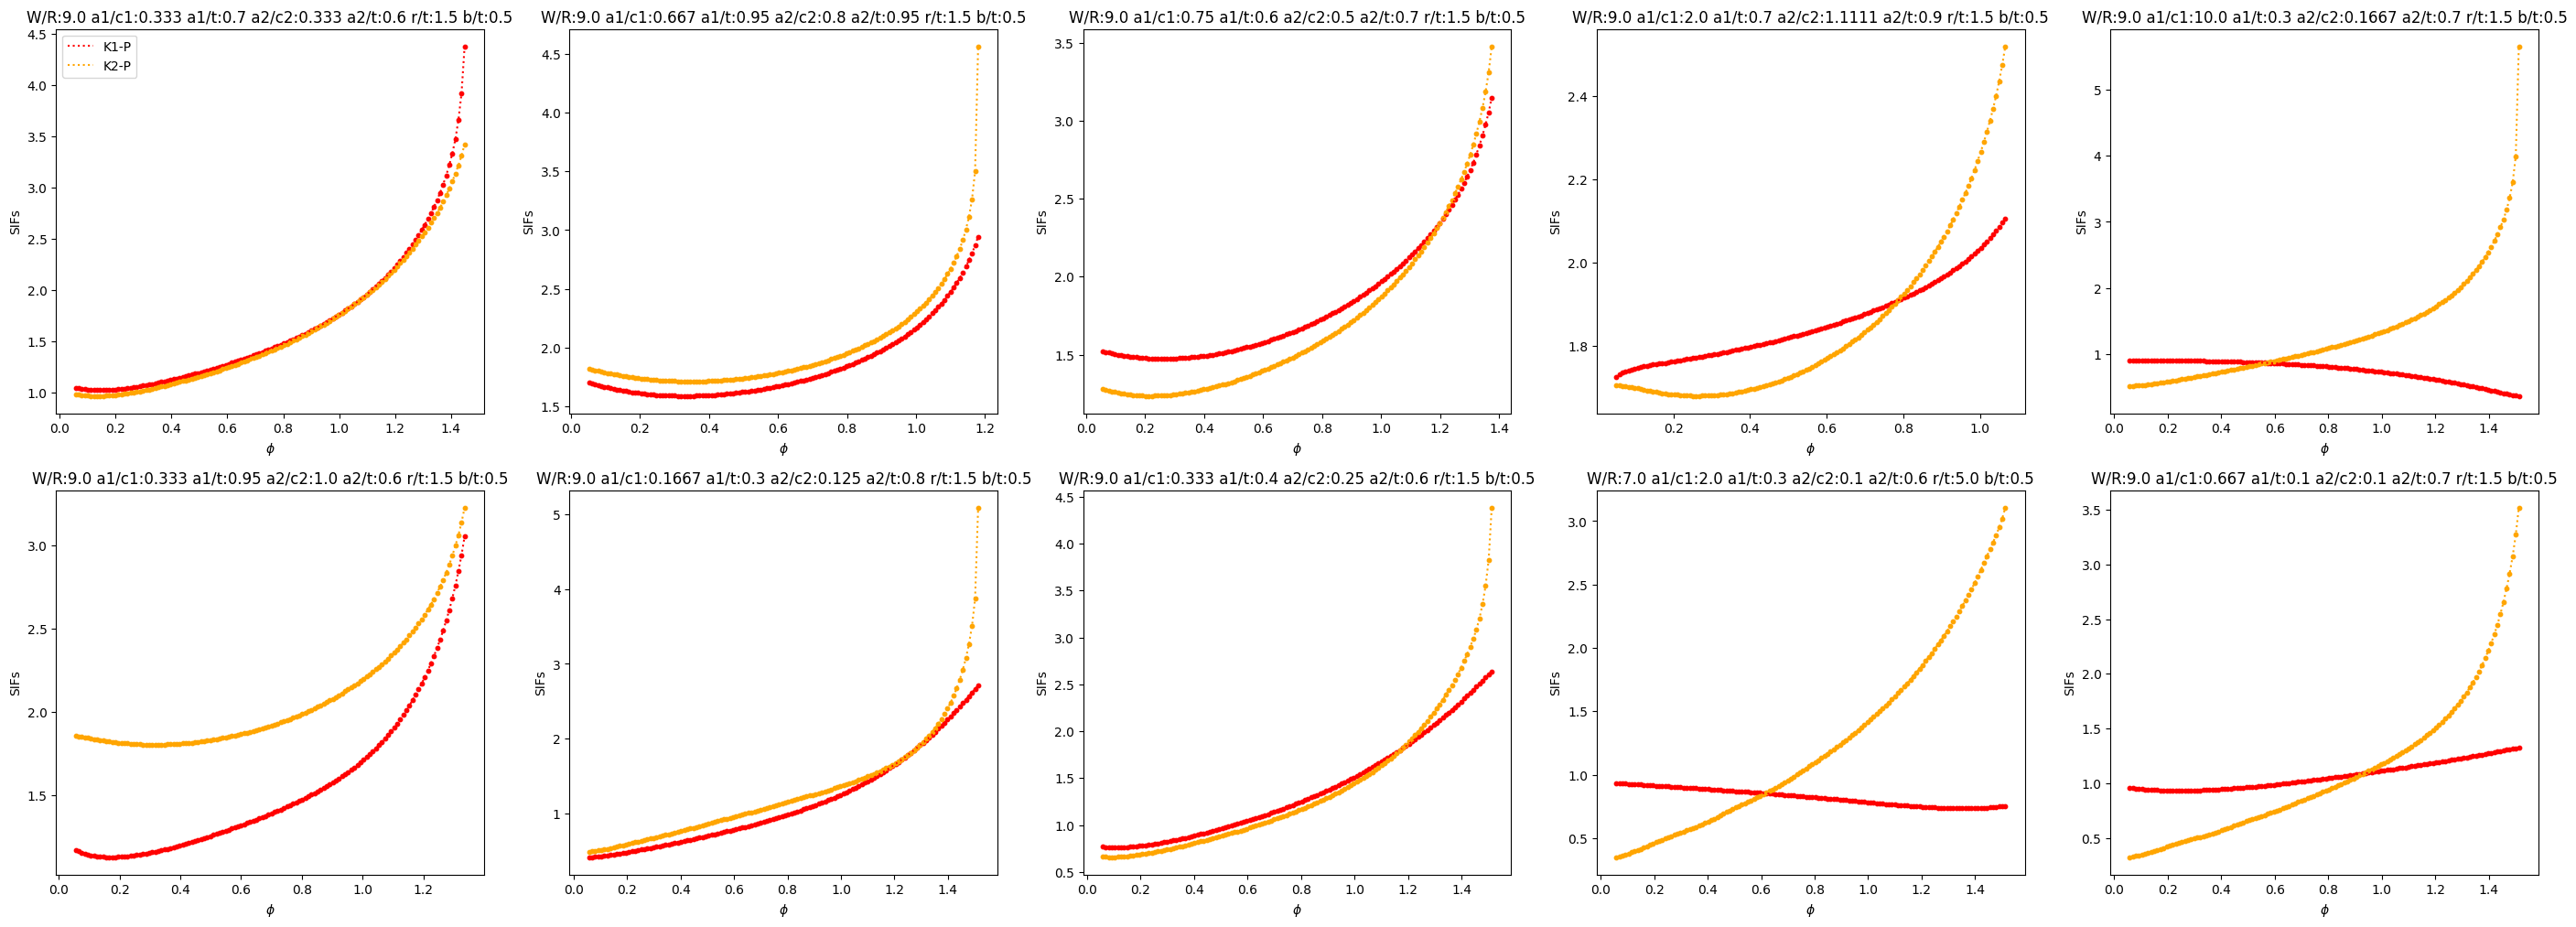

Total scenarios:  2720


In [8]:
d = df.to_numpy()

num_crack = np.unique(d[:,0])

np.random.seed(100)
fig, axs = plt.subplots(2, 5, figsize=(35,12))
for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(num_crack))
        data = d[idx*128:idx*128+128]
        W_R = np.unique(data[:,1])
        a1_c1 = np.unique(data[:,2])
        a1_t = np.unique(data[:,3])
        a2_c2 = np.unique(data[:,4])
        a2_t = np.unique(data[:,5])
        r_t = np.unique(data[:,6])
        b_t = np.unique(data[:,7])

        assert len(W_R) == 1
        assert len(a1_c1) == 1
        assert len(a1_t) == 1
        assert len(a2_c2) == 1
        assert len(a2_t) == 1
        assert len(r_t) == 1
        assert len(b_t) == 1

        axs[i,j].scatter(data[:,-8], data[:,-6], color='purple', s=10)
        axs[i,j].plot(data[:,-8], data[:,-6], label="K1-T", color='purple', linestyle=":")

        axs[i,j].scatter(data[:,-7], data[:,-5], color='blue', s=10)
        axs[i,j].plot(data[:,-7], data[:,-5], label="K2-T", color='blue', linestyle=":")

        axs[i,j].set_title("W/R:{} a1/c1:{} a1/t:{} a2/c2:{} a2/t:{} r/t:{} b/t:{}".format(W_R[0], a1_c1[0], a1_t[0], a2_c2[0], a2_t[0], r_t[0], b_t[0]))
        axs[i,j].set_ylabel("SIFs")
        axs[i,j].set_xlabel(r"$\phi$")
        
        if i == 0 and j == 0:
            axs[i,j].legend()

plt.show()


fig, axs = plt.subplots(2, 5, figsize=(35,12))
for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(num_crack))
        data = d[idx*128:idx*128+128]
        W_R = np.unique(data[:,1])
        a1_c1 = np.unique(data[:,2])
        a1_t = np.unique(data[:,3])
        a2_c2 = np.unique(data[:,4])
        a2_t = np.unique(data[:,5])
        r_t = np.unique(data[:,6])
        b_t = np.unique(data[:,7])

        assert len(W_R) == 1
        assert len(a1_c1) == 1
        assert len(a1_t) == 1
        assert len(a2_c2) == 1
        assert len(a2_t) == 1
        assert len(r_t) == 1
        assert len(b_t) == 1

        axs[i,j].scatter(data[:,-8], data[:,-4], color='green', s=10)
        axs[i,j].plot(data[:,-8], data[:,-4], label="K1-B", color='green', linestyle=":")

        axs[i,j].scatter(data[:,-7], data[:,-3], color='cyan', s=10)
        axs[i,j].plot(data[:,-7], data[:,-3], label="K2-B", color='cyan', linestyle=":")

        axs[i,j].set_title("W/R:{} a1/c1:{} a1/t:{} a2/c2:{} a2/t:{} r/t:{} b/t:{}".format(W_R[0], a1_c1[0], a1_t[0], a2_c2[0], a2_t[0], r_t[0], b_t[0]))
        axs[i,j].set_ylabel("SIFs")
        axs[i,j].set_xlabel(r"$\phi$")
        
        if i == 0 and j == 0:
            axs[i,j].legend()

plt.show()

fig, axs = plt.subplots(2, 5, figsize=(35,12))
for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(num_crack))
        data = d[idx*128:idx*128+128]
        W_R = np.unique(data[:,1])
        a1_c1 = np.unique(data[:,2])
        a1_t = np.unique(data[:,3])
        a2_c2 = np.unique(data[:,4])
        a2_t = np.unique(data[:,5])
        r_t = np.unique(data[:,6])
        b_t = np.unique(data[:,7])

        assert len(W_R) == 1
        assert len(a1_c1) == 1
        assert len(a1_t) == 1
        assert len(a2_c2) == 1
        assert len(a2_t) == 1
        assert len(r_t) == 1
        assert len(b_t) == 1

        axs[i,j].scatter(data[:,-8], data[:,-2], color='red', s=10)
        axs[i,j].plot(data[:,-8], data[:,-2], label="K1-P", color='red', linestyle=":")

        axs[i,j].scatter(data[:,-7], data[:,-1], color='orange', s=10)
        axs[i,j].plot(data[:,-7], data[:,-1], label="K2-P", color='orange', linestyle=":")

        axs[i,j].set_title("W/R:{} a1/c1:{} a1/t:{} a2/c2:{} a2/t:{} r/t:{} b/t:{}".format(W_R[0], a1_c1[0], a1_t[0], a2_c2[0], a2_t[0], r_t[0], b_t[0]))
        axs[i,j].set_ylabel("SIFs")
        axs[i,j].set_xlabel(r"$\phi$")
        
        if i == 0 and j == 0:
            axs[i,j].legend()

plt.show()

print("Total scenarios: ", len(num_crack))